# 计算机网络结果第三次作业

作业要求：

> 请复现“第十章 海龟交易系统”中介绍的六个长期趋势跟踪系统。
>
> 请以一段时间内的真实行情数据，
>
> 1）给出如《海龟交易法则（第四版）》中“表 10-1 6 个系统的历史表现对比”的测试结果。
>
> 2）并给出相应的结果说明和分析。自己的收获和感想也可以写进去。如果不能按时完成，请写明大致花费时间，原因。
>
> 注：行情数据可以通过 AkSahre 接口获得。如果是针对股票数据，可以考虑设定账户规模是 100 万人民币，单个标的持仓上限是 10 万人民币。


## 实验设置

- 实验目的：复现《海龟交易法则（第四版）》中介绍的六个长期趋势跟踪系统，并给出测试结果。
- 实验数据：美股 ETF 数据（后复权）。
  - 数据来源：[AkShare](https://akshare.akfamily.xyz/)。
  - 标的范围：澳元、英镑、谷物、可可、加拿大元、原油、棉花、欧元、欧洲美元、饲牛、⻩金、铜、⺠用燃料油、无铅汽油、日元、咖啡、牛、猪、墨⻄哥比索、天然气、大豆、糖、瑞士法郎、银、中期国债、⻓期国债以及小⻨
  - 实际标的（共计 13 支）：
    - 澳元 ETF-CurrencyShares (107.FXA)
    - 英镑 ETF-CurrencyShares (107.FXB)
    - 原油 ETF-PowerShares (107.DBO)
    - 二倍做空欧元 ETF-ProShares (107.EUO)
    - 二倍做多欧元 ETF-ProShares (107.ULE)
    - 欧元 ETF-CurrencyShares (107.FXE)
    - 日元 ETF-CurrencyShares (107.FXY)
    - 天然气 ETF-First Trust (107.FCG)
    - 大豆 (107.SOYB)
    - 瑞士法郎 ETF-CurrencyShares (107.FXF)
    - 10-20 年国债 ETF-iShares (107.TLH)
    - 美国超长期国债 ETF-Vanguard (107.EDV)
    - 美国 25 年+零息票国债 ETF-PIMCO (107.ZROZ)
  - 时间范围：2012-01-01 至 2024-05-20。
- 评价指标：复合平均增长率、平均月化收益率、夏普比率、最大回撤、年化波动率、胜率、盈亏比。
- 交易基本信息：
  - 交易单位：1 股。
  - 初始资金 100 万美元。
  - 单个标的持仓上限 28 万美元，超出上限时，卖出标的，将标的总价值降低至 27 万美元以下。
  - 超出趋势线时，每超出一个 ATR，买入或卖出总资产的 1%（份数向下取整）。
- 交易费用：
  - 来源：[老虎国际](https://www.itigerup.com/help/detail/74820992)。

|         费用类型         |                          收费标准                          |   收费方   |
| :----------------------: | :--------------------------------------------------------: | :--------: |
|         交易佣金         | $0.0039/股，每笔订单最低收取 $0.99，最多收取总交易额\*0.5% |  老虎国际  |
|          平台费          |   $0.004/股，每笔订单最低收取 $1，最多收取总交易额\*0.5%   |  老虎国际  |
|  外部机构费及交易活动费  | $0.00396/股，每笔订单最低收取 $0.99，最多收取总交易额\*1%  | 外部机构等 |
| 证监会费（仅卖单时收取） |       $0.0000278 \* 总交易额，每笔成交最低收取 $0.01       | 美国证监会 |


## 原理和实现


In [1]:
from typing import Callable
import akshare as ak
import os.path
import matplotlib as mpl
import pandas as pd
import pathlib
import datetime
import math
import numpy as np


# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Songti SC"]
mpl.rcParams["axes.unicode_minus"] = False


def get_data(path: str, getter: Callable[[], pd.DataFrame], force: bool = False) -> pd.DataFrame:
    '''
    从akshare获取数据
    path: 数据文件的路径
    getter: 获取数据的函数
    force: 是否强制重新获取数据
    返回值: pd.DataFrame
    '''
    p = pathlib.Path("data") / path
    if os.path.exists(p) and not force:
        return pd.read_pickle(p)
    else:
        data = getter()
        data.to_pickle(p)
        return data


# 获取美股实时行情数据
stock = get_data('stock_us_spot_em.pkl', ak.stock_us_spot_em)
print(stock.columns)
stock.loc[:, ['名称', '代码']].to_csv('美股列表.csv')

Index(['序号', '名称', '最新价', '涨跌额', '涨跌幅', '开盘价', '最高价', '最低价', '昨收价', '总市值',
       '市盈率', '成交量', '成交额', '振幅', '换手率', '代码'],
      dtype='object')


In [2]:
# 根据符号获取指定标的的代码
codes = {
    # 澳元
    '澳元ETF-CurrencyShares': '107.FXA',

    # 英镑
    '英镑ETF-CurrencyShares': '107.FXB',

    # 谷物
    # 可可
    # 加拿大元

    # 原油
    '原油ETF-PowerShares': '107.DBO',
    # '二倍做空原油ETF-ProShares': '107.SCO',
    # '二倍做多原油ETF-ProShares': '107.UCO',
    # '美国原油基金(近12月合约平均)': '107.USL',
    # '美国布伦特原油基金': '107.BNO',
    # '美国原油基金': '107.USO',
    # '马拉松原油': '106.MPC',

    # 棉花
    # 欧元
    '二倍做空欧元ETF-ProShares': '107.EUO',
    # '二倍做多欧元ETF-ProShares': '107.ULE', Missed on 2019-03-26
    '欧元ETF-CurrencyShares': '107.FXE',

    # 欧洲美元

    # 饲牛

    # ⻩金

    # 铜
    # 107.COPX 2010-04-20
    # '铜矿ETF-Global X': '107.COPX',

    # ⺠用燃料油

    # 无铅汽油

    # 日元
    # '二倍做空日元ETF-ProShares': '107.YCS',
    '日元ETF-CurrencyShares': '107.FXY',
    # '二倍做多日元ETF-ProShares': '107.YCL',

    # 咖啡
    # 牛
    # 猪
    # 墨⻄哥比索

    # 天然气
    # '二倍做多天然气ETF-ProShares': '107.BOIL',
    # '美国天然气基金': '107.UNG',
    '天然气ETF-First Trust': '107.FCG',
    # '二倍做空天然气ETF-ProShares': '107.KOLD',

    # 大豆
    '大豆': '107.SOYB',

    # 糖

    # 瑞士法郎
    '瑞士法郎ETF-CurrencyShares': '107.FXF',

    # 银
    # 106.PAAS 2023-04-18
    # '泛美白银': '106.PAAS',

    # 中期国债
    # 105.SHY 2017-08-07
    # '1-3年国债ETF-iShares': '105.SHY',

    # ⻓期国债
    # '三倍做空20年+国债ETF-Direxion': '107.TMV',
    # '二倍做空20年+国债ETF-ProShares': '107.TBT',
    # '做空20年+国债ETF-ProShares': '107.TBF',
    '10-20年国债ETF-iShares': '107.TLH',
    # 105.TLT 2016-02-02
    # '20年+国债ETF-iShares': '105.TLT',
    '美国超长期国债ETF-Vanguard': '107.EDV',
    '美国25年+零息票国债ETF-PIMCO': '107.ZROZ',
    # '二倍做多20年+国债ETF-ProShares': '107.UBT',
    # '三倍做多20年+国债ETF-Direxion': '107.TMF',

    # 小⻨
}

data_set: dict[str, pd.DataFrame] = {}
for name, code in codes.items():
    # print(name, code)
    data = get_data(
        f'{code}.pkl',
        lambda: ak.stock_us_hist(
            symbol=code, period='daily', start_date='20000101', end_date='20240520', adjust='hfq'
        )
    )
    # print(data.loc[:, '日期'])
    print(code, data.loc[0, '日期'], data.loc[len(data) - 1, '日期'])
    data.loc[:, '日期'] = pd.to_datetime(data.loc[:, '日期'])
    data.set_index('日期', inplace=True)
    data_set.setdefault(code, data)
print(data.columns)

107.FXA 2006-06-26 2024-05-20
107.FXB 2006-06-26 2024-05-20
107.DBO 2007-01-05 2024-05-20
107.EUO 2008-11-25 2024-05-20
107.FXE 2005-12-12 2024-05-20
107.FXY 2007-02-13 2024-05-20
107.FCG 2007-05-11 2024-05-20
107.SOYB 2011-09-19 2024-05-20
107.FXF 2006-06-26 2024-05-20
107.TLH 2007-01-11 2024-05-20
107.EDV 2008-01-29 2024-05-20
107.ZROZ 2009-11-04 2024-05-20
Index(['开盘', '收盘', '最高', '最低', '成交量', '成交额', '振幅', '涨跌幅', '涨跌额', '换手率'], dtype='object')


In [3]:
# 初始资金
INITIAL = 1000000
# 单个标的最大持仓
LIMIT_CEIL = INITIAL * math.ceil(100 / math.sqrt(len(codes))) / 100
LIMIT_FLOOR = INITIAL * math.floor(100 / math.sqrt(len(codes))) / 100
print(f"初始资金：{INITIAL}，单个标的最大持仓：{LIMIT_CEIL}。")

初始资金：1000000，单个标的最大持仓：290000.0。


In [4]:


class Agent:
    '''
    模拟交易代理。
    参见 https://www.itigerup.com/help/detail/74820992
    '''
    extra: float = 0

    @staticmethod
    def clamp(value: float, floor: float, ceil: float) -> float:
        '''
        将 value 限制在 floor 和 ceil 之间。
        '''
        return max(floor, min(ceil, value))

    @staticmethod
    def p1(count: int, price: float) -> float:
        '''
        代理服务费用-交易佣金。
        '''
        return Agent.clamp(count * 0.0039, 0.99, count * price * 0.005)

    @staticmethod
    def p2(count: int, price: float) -> float:
        '''
        代理服务费用-平台费。
        '''
        return Agent.clamp(count * 0.004, 1, count * price * 0.005)

    @staticmethod
    def p3(count: int, price: float) -> float:
        '''
        代收费用-外部机构费及交易活动费。
        '''
        return Agent.clamp(count * 0.00396, 0.99, count * price * 0.01)

    @staticmethod
    def p4(count: int, price: float) -> float:
        '''
        代收费用-证监会费（仅卖单时收取）
        '''
        return max(count * price * 0.0000278, 0.01)

    def get(self):
        return self.extra

    def buy(self, count: int, price: float, ensure: bool) -> float:
        '''
        计算买入指定数量的标的所需的金额。
        '''
        p1 = self.p1(count, price)
        p2 = self.p2(count, price)
        p3 = self.p3(count, price)
        p = p1 + p2 + p3
        if ensure:
            self.extra += p
        return count * price + p

    def sell(self, count: int, price: float, ensure: bool) -> float:
        '''
        计算卖出指定数量的标的所得的金额。
        '''
        p1 = self.p1(count, price)
        p2 = self.p2(count, price)
        p3 = self.p3(count, price)
        p4 = self.p4(count, price)
        p = p1 + p2 + p3 + p4
        if ensure:
            self.extra += p
        assert count * price - p >= 0, f"count={count}, price={price}, p={p}"
        return count * price - p

In [5]:
# ATR通道突破系统

def atr_channel_breakout(n: int = 14) -> pd.DataFrame:
    '''
    计算ATR
    data: pd.DataFrame
    n: int
    返回值: pd.DataFrame
    '''
    agent = Agent()
    cash = INITIAL
    stocks: dict[str, int] = {}
    for code, data in data_set.items():
        stocks.setdefault(code, 0)
        assert (data['收盘'] <= data['最高']).all(), (data['最高'] - data['收盘'])
        assert (data['最低'] <= data['收盘']).all(), (data['最低'] - data['收盘'])
        data['真实波幅'] = data.apply(lambda x: abs(x['最高'] - x['最低']), axis=1)
        # print(n)
        data['平均真实波幅'] = data['真实波幅'].rolling(n).mean()
        data['350日移动平均收盘价'] = data['收盘'].rolling(
            datetime.timedelta(350)).mean()
        data['通道顶部'] = data['350日移动平均收盘价'] + 7 * data['平均真实波幅']
        data['通道底部'] = data['350日移动平均收盘价'] - 3 * data['平均真实波幅']

    result = []

    days = data_set['107.FXA'][data_set['107.FXA'].index > '2012-01-01'].index

    yesterday_total = INITIAL

    for i in range(len(days)):
        total = 0
        for code, data in data_set.items():
            yesterday = days[i - 1]
            today = days[i]
            open_today: float = data.loc[today, '开盘']
            close_yesterday: float = data.loc[yesterday, '收盘']
            close_today: float = data.loc[today, '收盘']
            upper_bound: float = data.loc[yesterday, '通道顶部']
            lower_bound: float = data.loc[yesterday, '通道底部']
            atr: float = data.loc[yesterday, '平均真实波幅']

            if close_yesterday * stocks[code] > LIMIT_CEIL:
                # 卖出
                # 卖出后的持仓量不能超过最大持仓量向下取整的值
                to_sell = (stocks[code] * open_today -
                           LIMIT_FLOOR) // open_today
                assert to_sell % 1 == 0
                to_sell = int(to_sell)
                # assert to_sell >= 0, (to_sell, stocks[code], cash)
                if to_sell > 0:
                    cash += agent.sell(to_sell, open_today, True)
                    stocks[code] -= to_sell
                assert cash >= 0
            elif close_yesterday > upper_bound:
                # 买入
                if stocks[code] * close_yesterday < LIMIT_CEIL:
                    # 不能超过最大持仓量向下取整的值，同时要考虑昨日收盘价超过通道顶部的量
                    to_buy = min(
                        (LIMIT_FLOOR - stocks[code] *
                         close_yesterday) // close_yesterday,
                        ((close_yesterday - upper_bound) / atr *
                         0.01 * yesterday_total) // close_yesterday,
                        cash // open_today
                    )
                    # assert to_buy >= 0, (to_buy,
                    #                      stocks[code], close_yesterday, open_today, cash)
                    assert to_buy % 1 == 0
                    to_buy = int(to_buy)
                    while to_buy > 0 and agent.sell(to_buy, open_today, False) > cash:
                        to_buy -= 1
                    if to_buy > 0:
                        stocks[code] += to_buy
                        cash -= agent.sell(to_buy, open_today, True)
                    assert cash >= 0
            elif close_yesterday < lower_bound:
                # 卖出
                if stocks[code] > 0:
                    cash += agent.sell(stocks[code], open_today, True)
                    stocks[code] = 0
                assert cash >= 0
            total += close_today * stocks[code]
        total += cash
        yesterday_total = total
        r = {
            '日期': today,
            '现金': cash,
            '资金': total,
            '累计额外费用': agent.get(),
        }
        r.update({
            f'{code}-stock': stocks[code] for code, _ in data_set.items()
        })
        r.update({
            f'{code}-value': data.loc[today, '收盘'] * stocks[code] for code, data in data_set.items()
        })
        result.append(r)
    return pd.DataFrame(result)

资金        1392879.49787
现金         842374.81787
累计额外费用     11131.089313
Name: 3113, dtype: object


,现金,资金,累计额外费用,107.FXA-stock,107.FXB-stock,107.DBO-stock,107.EUO-stock,107.FXE-stock,107.FXY-stock,107.FCG-stock,...,107.DBO-value,107.EUO-value,107.FXE-value,107.FXY-value,107.FCG-value,107.SOYB-value,107.FXF-value,107.TLH-value,107.EDV-value,107.ZROZ-value
count,3.114000e+03,3.114000e+03,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,...,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000,3114.000000
mean,3.294133e+05,1.131046e+06,4869.607221,385.921323,460.009955,4375.830764,5201.048812,616.799294,240.764611,3437.571612,...,59231.108791,131838.165673,72666.864000,22315.807206,75494.017816,51010.176780,58621.381460,88939.628176,70058.821750,77580.973693
std,3.557736e+05,2.050681e+05,3204.782729,1032.742689,788.490188,8117.709708,5407.059774,1026.965205,753.620145,5134.536315,...,108574.799324,134447.938365,120415.322488,69517.435757,114153.057345,98151.836617,103001.669995,123810.623260,108464.744034,112612.673934
min,3.076529e+00,9.198151e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.303618e+01,9.718080e+05,2002.486993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.279066e+05,1.022580e+06,4908.485432,0.000000,0.000000,0.000000,2895.000000,0.000000,0.000000,0.000000,...,0.000000,67700.655000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.648986e+05,1.257074e+06,7193.046681,0.000000,698.000000,696.000000,10711.000000,1780.000000,0.000000,10130.000000,...,18696.877500,278221.578750,199391.257500,0.000000,209891.862500,72235.760000,68133.520000,270965.717500,134939.497500,183325.450000
max,1.355821e+06,1.665144e+06,11131.089313,3793.000000,2362.000000,27640.000000,14752.000000,2836.000000,3296.000000,16627.000000,...,300301.680000,298149.480000,291597.520000,293612.970000,303760.170000,293707.080000,293872.176000,292874.400000,294112.000000,295608.880000


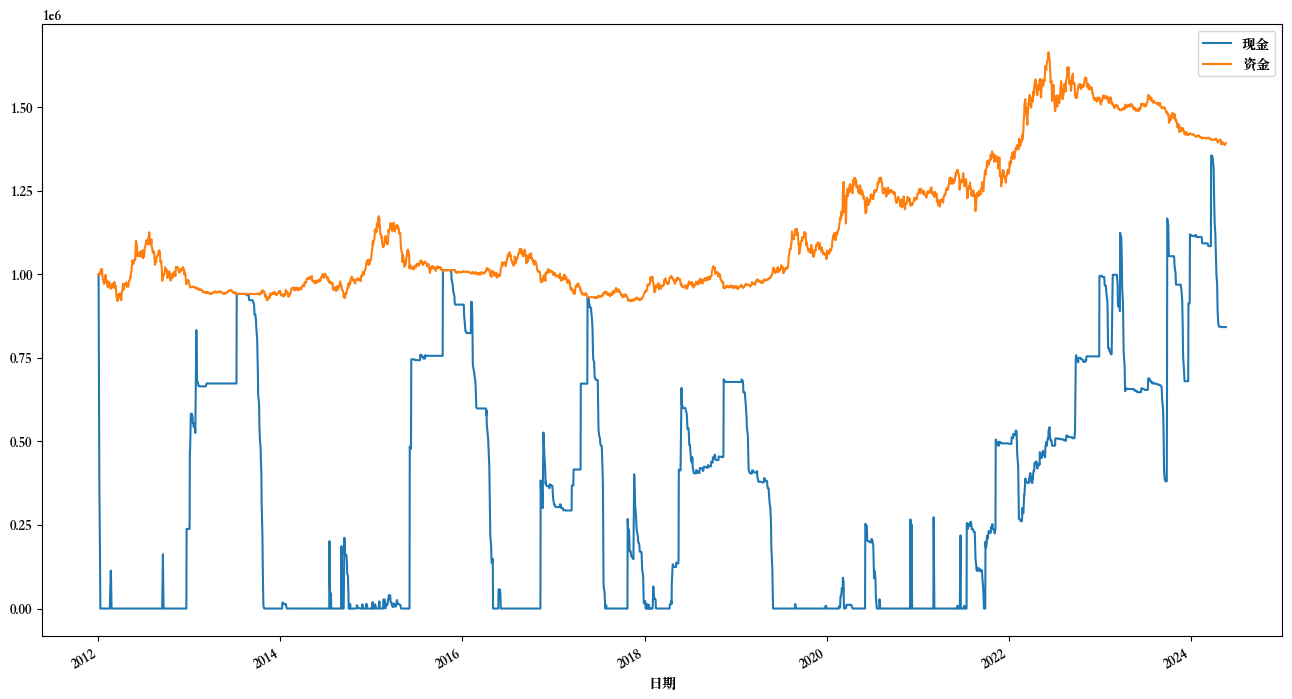

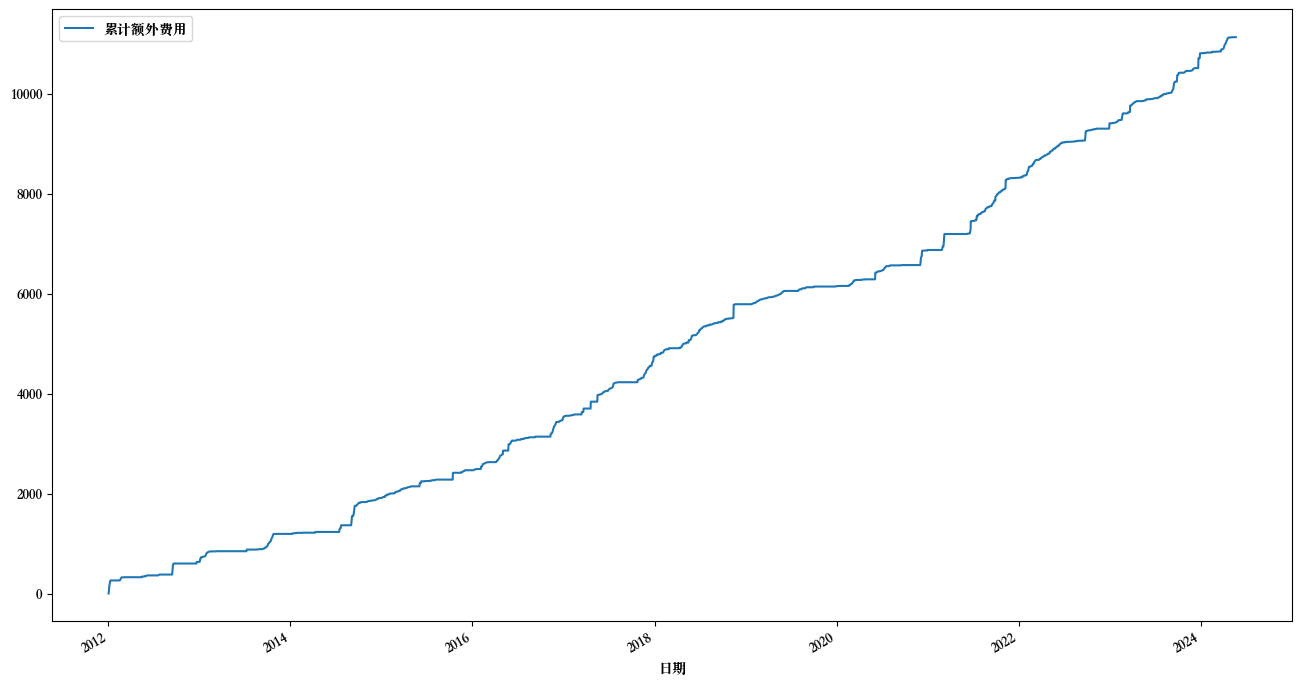

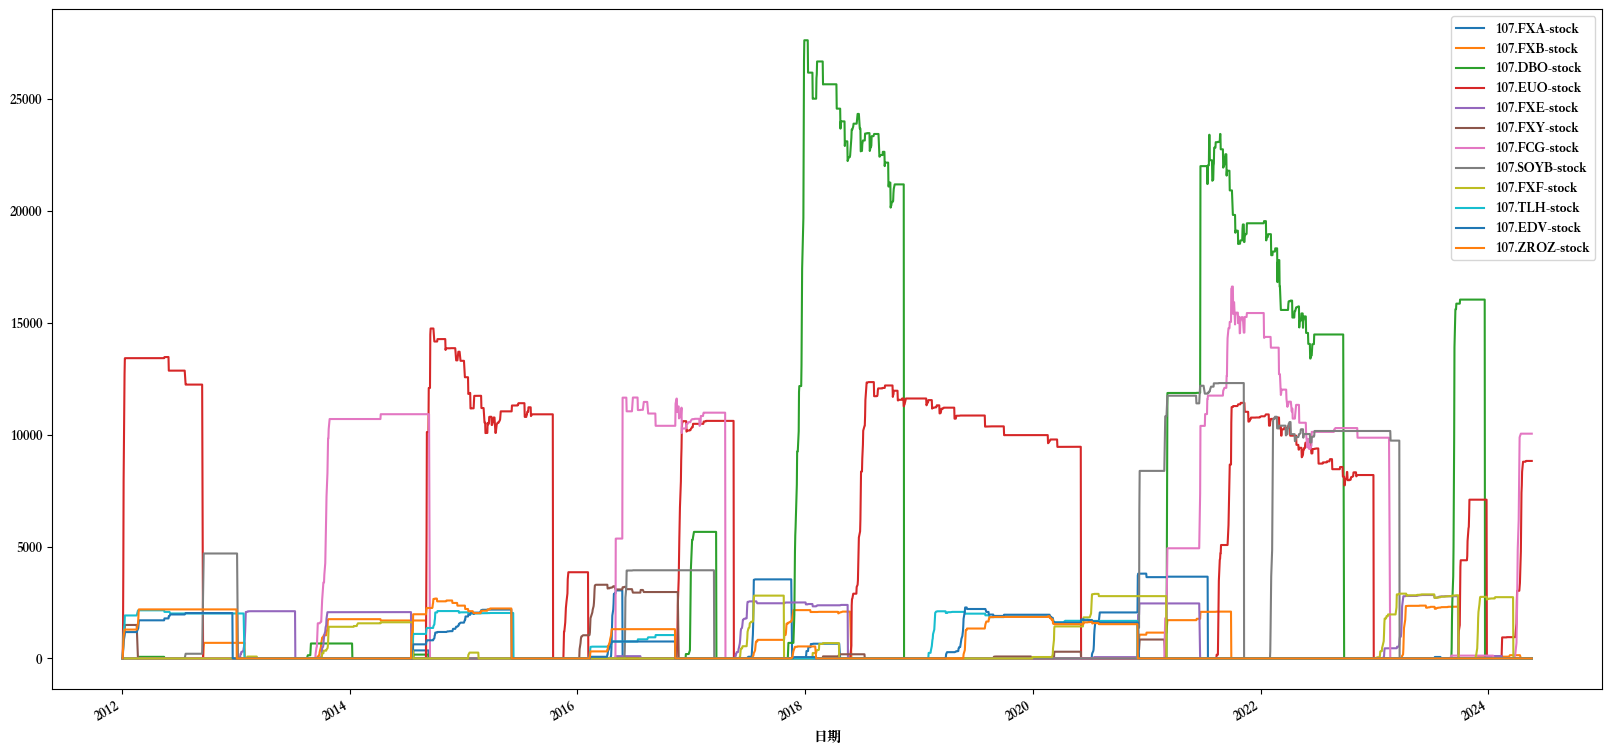

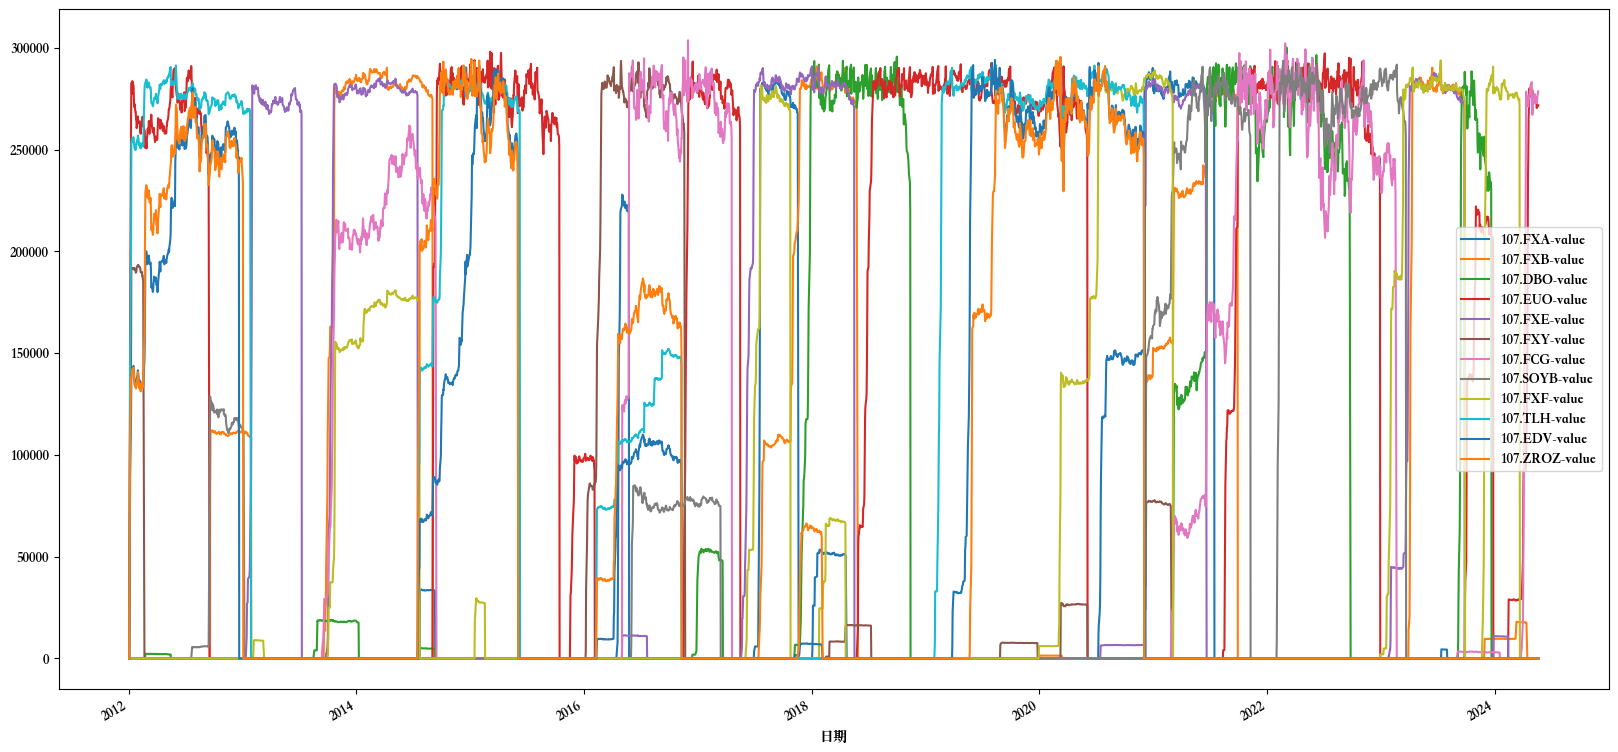

In [6]:
atr_cb = atr_channel_breakout()
atr_cb.plot(y=['现金', '资金'], x='日期', figsize=(16, 9))
atr_cb.plot(y=['累计额外费用'], x='日期', figsize=(16, 9))
atr_cb.plot(y=[f'{code}-stock' for code in data_set.keys()],
            x='日期', figsize=(20, 10))
atr_cb.plot(y=[f'{code}-value' for code in data_set.keys()],
            x='日期', figsize=(20, 10))
print(atr_cb.iloc[-1].loc[['资金', '现金', '累计额外费用']])
atr_cb.describe(exclude=[np.datetime64])

## 实验结果与分析

### 系统表现对比

| System | CAGR% | MAR | Sharpe | Trades | W%  | Max DD | DD Length |
| :----: | :---: | :-: | :----: | :----: | :-: | :----: | :-------: |
